In [2]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch.optim import Optimizer

from sgd import SGD
from dog import DoG, LDoG
from dadapt import DAdaptSGD, DAdaptDual
from dav2 import DualAveragingV2
from averager import PolynomialDecayAverager

from abc import abstractmethod
from tqdm.notebook import tqdm
import time

In [3]:
def add_gaussian_noise(tensor: torch.Tensor, mean: float = 0, std: float = 1):
    return tensor + (torch.randn_like(tensor) + mean) * std

In [4]:
class TorchModel:
    def __init__(self, n_features: int, init_point: torch.Tensor = None):
        self.N = n_features
        self.optimum = float('inf')
        self.x = None
        self.optimizer = None
        self.scheduler = None
        self.optimal_x = None

    def set_optimizer(self, optimizer: Optimizer):
        self.optimizer = optimizer

    def set_scheduler(self, scheduler: PolynomialDecayAverager):
        self.scheduler = scheduler

    @abstractmethod
    def loss(self, P: torch.Tensor, q: torch.Tensor):
        raise NotImplementedError("must override loss")

    def optimize(self, P: torch.Tensor, q: torch.Tensor, optimal_point,
                 max_iter: int = 10000, log_per: int = 1000, is_noisy: bool = True, noise_std: float = 0.1):
        print(self.x)
        self.P = P
        self.q = q
        point_distance_list = []
        value_distance_list = []
        optimal_value = self.compute_value(optimal_point)

        for _ in tqdm(range(max_iter)):
            self.optimizer.zero_grad()
            loss = self.loss(P, q)
            loss.backward()
            if is_noisy:
                self.x.grad += add_gaussian_noise(self.x.grad, std=noise_std)
            self.optimizer.step()
            if self.scheduler is not None:
                self.scheduler.step()

            current_value = self.compute_value(self.x.detach().numpy())
            point_distance = np.linalg.norm(self.x.detach().numpy() - optimal_point)
            value_distance = current_value - optimal_value
            point_distance_list.append(point_distance)
            value_distance_list.append(value_distance)
            if _ % log_per == 0:
                tqdm.write(f"Iter: {_}, \tPoint Distance (d_i) from Optimal: {'%.6f' % point_distance}, \tValue Distance from Optimal: \t{'%.6f' % value_distance}", end='\r')
                time.sleep(1)

            if current_value < self.optimum:
                self.optimal_x = self.x
                self.optimum = current_value

        return point_distance_list, value_distance_list

    @abstractmethod
    def optimal_value(self):
        raise NotImplementedError("must override optimal_value")

    @abstractmethod
    def compute_value(self):
        raise NotImplementedError("must override compute_value")

    def params(self):
        return [self.x]

In [5]:
class TorchQuadModel(TorchModel):
    def __init__(self, n_features: int, init_point: torch.Tensor = None, **kwargs):
        super().__init__(n_features, init_point, **kwargs)
        if init_point is None:
            self.x = torch.randn(self.N, requires_grad=True)
        else:
            self.x = init_point.clone().detach()
            self.x.requires_grad = True

    def loss(self, P: torch.Tensor, q: torch.Tensor):
        x1 = torch.matmul(self.x, P) # x1 = x^T P
        z = torch.matmul(x1, self.x) # z = x1 x = x^T P x

        # x^T P x - q^T x
        return z - torch.matmul(q, self.x)

    def optimal_value(self):
        return self.optimum

    def compute_value(self, point: np.ndarray):
        P = self.P.detach().numpy()
        q = self.q.detach().numpy()
        # print(point)
        return point.T @ P @ point - q @ point

In [6]:
N = 5 # Matrix Size
A = np.random.rand(N, N)
P = torch.from_numpy((A.T @ A).astype('float32'))
q = torch.from_numpy(np.random.rand(N).astype(dtype='float32'))

In [7]:
from solver import QuadraticSolver

qs = QuadraticSolver(N, P.detach().numpy(), q.detach().numpy())
qs.optimal_point()
qs.optimal_value()

-10.033505306495664

In [8]:
def quadratic_model_runner(optimizer: Optimizer, model: TorchModel,
                           P: torch.Tensor,
                           q: torch.Tensor,
                           optimal_point: float,
                           max_iter: int = 10000,
                           log_per_iteration: int = 1000,
                           is_noisy: bool = True,
                           noise_std: float = 0.01):
    model.set_optimizer(optimizer)
    point_distance_list, value_distance_list = model.optimize(P,
                                                              q,
                                                              optimal_point,
                                                              max_iter,
                                                              log_per_iteration,
                                                              is_noisy, noise_std)
    log_distance_list = np.log(np.abs(np.array(value_distance_list)))
    print()
    print()
    time.sleep(1)

    return point_distance_list, value_distance_list, log_distance_list

In [11]:
iterations = 100001
init = torch.randn(N, requires_grad=True)


# noise_levels = [0.01, 0.1, 1, 10, 100]
noise_levels = [0]

value_distances = {}
log_value_distances = {}
point_distances = {}

for j, nl in enumerate(noise_levels):
    print(f"Noise STD = {nl}")

    # SGD Method
    sgd_model = TorchQuadModel(N, init)
    sgd_optimizer = SGD(sgd_model.params(), lr = 0.001)

    # DoG Method
    dog_model = TorchQuadModel(N, init)
    dog_optimizer = DoG(dog_model.params())

    # D-Adaptation (SGD) Method
    dadapt_sgd_model = TorchQuadModel(N, init)
    dadapt_sgd_optimizer = DAdaptSGD(dadapt_sgd_model.params(), lr = 0.01)

    # D-Adaptation (Dual Averaging) Method
    dadapt_dual_model = TorchQuadModel(N, init)
    dadapt_dual_optimizer = DAdaptDual(dadapt_dual_model.params())

    # Dual Averaging using DoG LRs
    dualv2_model = TorchQuadModel(N, init)
    dualv2_optimizer = DualAveragingV2(dualv2_model.params())


    optimizers = [[sgd_optimizer, sgd_model],
                [dog_optimizer, dog_model],
                [dadapt_sgd_optimizer, dadapt_sgd_model],
                [dadapt_dual_optimizer, dadapt_dual_model],
                [dualv2_optimizer, dualv2_model]]

    for i, (optimizer, model) in enumerate(optimizers):
        optimizer_name = optimizer.__class__.__name__
        print(f"{optimizer_name} Method")
        point_dist_list, value_dist_list, log_dist_list = quadratic_model_runner(optimizer,
                                                                                 model,
                                                                                 P,
                                                                                 q,
                                                                                 qs.optimal_point(), max_iter=iterations, log_per_iteration=iterations-1,
                                                                                 noise_std=nl)
        log_value_distances[optimizer_name] = log_dist_list
        value_distances[optimizer_name] = value_dist_list
        point_distances[optimizer_name] = point_dist_list


Noise STD = 0
SGD Method
tensor([ 0.8807, -0.4436,  0.1455,  1.0480, -0.1875], requires_grad=True)


  0%|          | 0/100001 [00:00<?, ?it/s]

Iter: 100000, 	Point Distance (d_i) from Optimal: 0.025375, 	Value Distance from Optimal: 	0.000018

DoG Method
tensor([ 0.8807, -0.4436,  0.1455,  1.0480, -0.1875], requires_grad=True)


  0%|          | 0/100001 [00:00<?, ?it/s]

Iter: 100000, 	Point Distance (d_i) from Optimal: 0.000126, 	Value Distance from Optimal: 	-0.000044

DAdaptSGD Method
tensor([ 0.8807, -0.4436,  0.1455,  1.0480, -0.1875], requires_grad=True)


  0%|          | 0/100001 [00:00<?, ?it/s]

Iter: 100000, 	Point Distance (d_i) from Optimal: 0.002177, 	Value Distance from Optimal: 	0.000044

DAdaptDual Method
tensor([ 0.8807, -0.4436,  0.1455,  1.0480, -0.1875], requires_grad=True)


  0%|          | 0/100001 [00:00<?, ?it/s]

Iter: 100000, 	Point Distance (d_i) from Optimal: 0.000392, 	Value Distance from Optimal: 	-0.000024

DualAveragingV2 Method
tensor([ 0.8807, -0.4436,  0.1455,  1.0480, -0.1875], requires_grad=True)


  0%|          | 0/100001 [00:00<?, ?it/s]

Iter: 100000, 	Point Distance (d_i) from Optimal: 0.000161, 	Value Distance from Optimal: 	-0.000030



SGD Method
DoG Method
DAdaptSGD Method
DAdaptDual Method
DualAveragingV2 Method


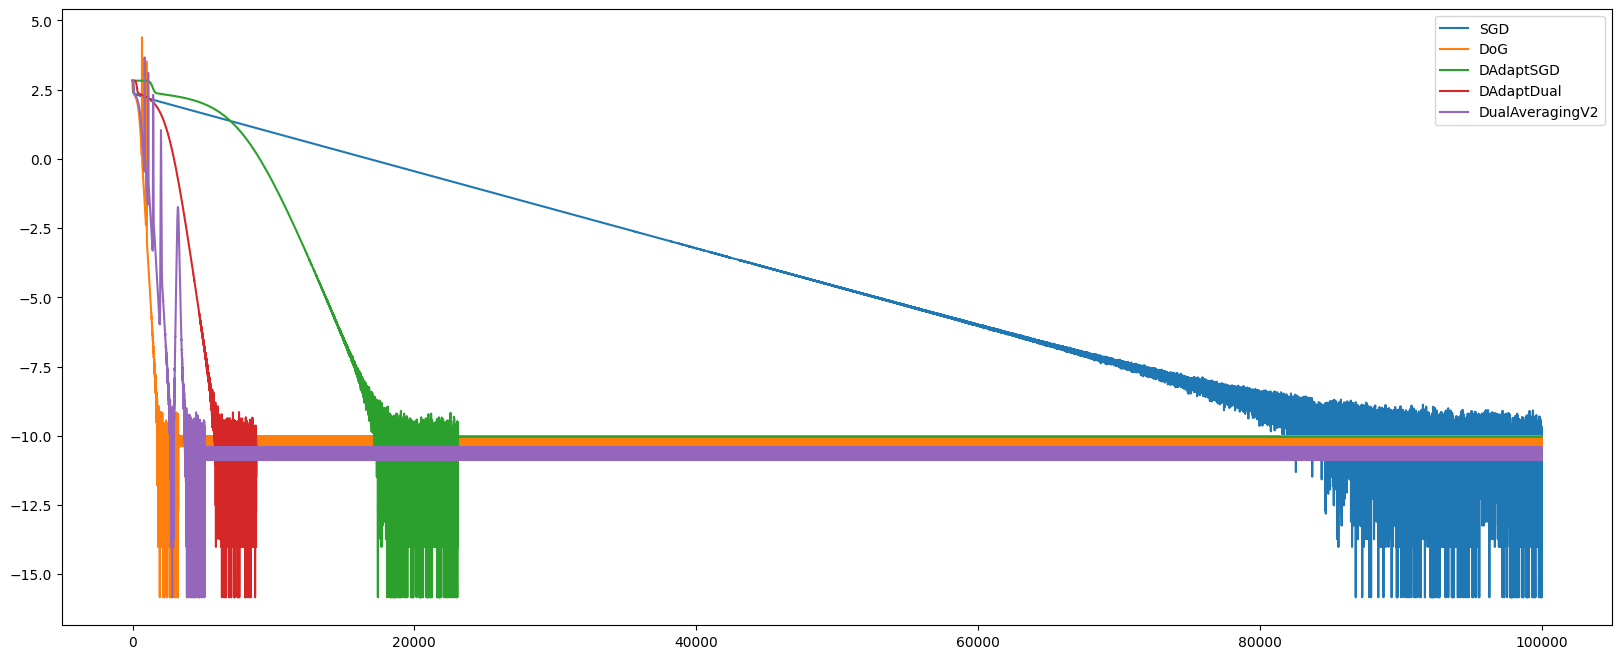

SGD Method
DoG Method
DAdaptSGD Method
DAdaptDual Method
DualAveragingV2 Method


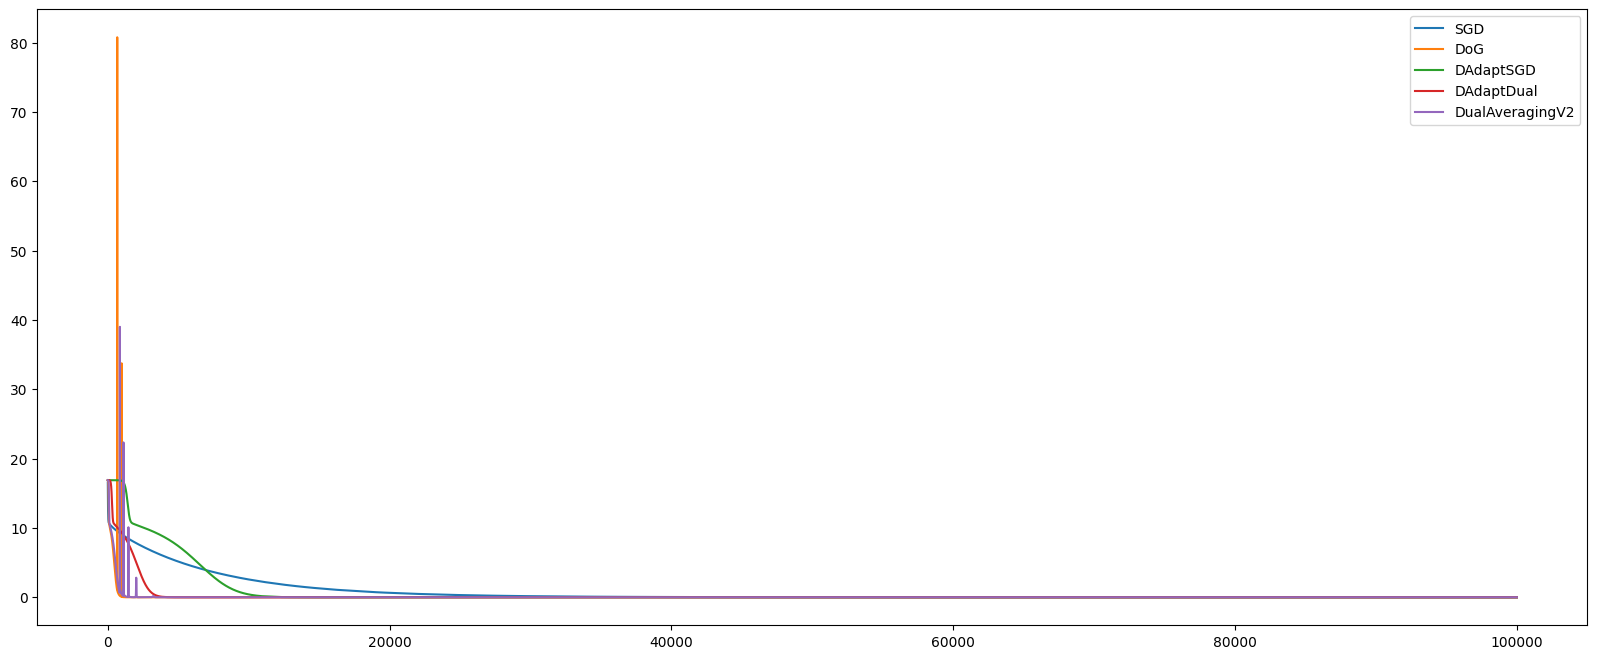

In [20]:
plt.figure(figsize=(20,8))
for i, (optimizer, model) in enumerate(optimizers):
        optimizer_name = optimizer.__class__.__name__
        print(f"{optimizer_name} Method")
        plt.plot(log_value_distances[optimizer_name], label=optimizer_name)
    # ax1.legend()

plt.legend()
plt.show()

plt.figure(figsize=(20,8))
for i, (optimizer, model) in enumerate(optimizers):
        optimizer_name = optimizer.__class__.__name__
        print(f"{optimizer_name} Method")
        plt.plot(value_distances[optimizer_name], label=optimizer_name)
    # ax1.legend()

plt.legend()
plt.show()

In [ ]:
print(f"Actual optimal point: \t{qs.optimal_value()}")
print(f"DoG optimal point: \t{dog_model.optimal_value()}")
print(f"SGD optimal point: \t{sgd_model.optimal_value()}")
print(f"D-Adapt (SGD) optimal point: \t{dadapt_sgd_model.optimal_value()}")
print(f"D-Adapt (DA) optimal point: \t{dadapt_dual_model.optimal_value()}")

In [ ]:
iterations = 1000001
# init = torch.randn(N, requires_grad=True)

# SGD Method
sgd_model = TorchQuadModel(N, init)
sgd_optimizer = SGD(sgd_model.params(), lr = 0.00001)

# DoG Method
dog_model = TorchQuadModel(N, init)
dog_optimizer = DoG(dog_model.params())

# D-Adaptation (SGD) Method
dadapt_sgd_model = TorchQuadModel(N, init)
dadapt_sgd_optimizer = DAdaptSGD(dadapt_sgd_model.params(), lr = 0.01)

# D-Adaptation (Dual Averaging) Method
dadapt_dual_model = TorchQuadModel(N, init)
dadapt_dual_optimizer = DAdaptDual(dadapt_dual_model.params())


optimizers = [[sgd_optimizer, sgd_model],
            [dog_optimizer, dog_model],
            [dadapt_sgd_optimizer, dadapt_sgd_model],
            [dadapt_dual_optimizer, dadapt_dual_model]]

fig, (ax1, ax2) = plt.subplots(2, figsize=(20, 10))
ax1.set_title("Log Distance to Opt")
ax2.set_title("Value Distance to Opt")
for i, (optimizer, model) in enumerate(optimizers):
    optimizer_name = optimizer.__class__.__name__
    print(f"{optimizer_name} Method")
    point_dist_list, value_dist_list, log_dist_list = quadratic_model_runner(optimizer,
                                                                                model, P,
                                                                                q,
                                                                                qs.optimal_point(), max_iter=iterations, log_per_iteration=1000000,
                                                                                is_noisy=True,
                                                                                noise_std=100)

    ax1.plot(log_dist_list, label=optimizer_name)
    ax2.plot(value_dist_list, label=optimizer_name)
ax1.legend()
ax2.legend()
plt.show()

In [21]:
print(f"Actual optimal point: \t{qs.optimal_value()}")
print(f"DoG optimal point: \t{dog_model.optimal_value()}")
print(f"SGD optimal point: \t{sgd_model.optimal_value()}")
print(f"D-Adapt (SGD) optimal point: \t{dadapt_sgd_model.optimal_value()}")
print(f"D-Adapt (DA) optimal point: \t{dadapt_dual_model.optimal_value()}")

Actual optimal point: 	-10.033505306495664
DoG optimal point: 	-10.033591270446777
SGD optimal point: 	-10.033592224121094
D-Adapt (SGD) optimal point: 	-10.033609390258789
D-Adapt (DA) optimal point: 	-10.033612251281738
